In [85]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

classifier_model ="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4" 

IMAGE_SHAPE = (224, 224)

In [86]:
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper
grace_hopper = np.array(grace_hopper)/255.0



In [87]:

result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape



(1, 1001)

In [88]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class



653

In [89]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


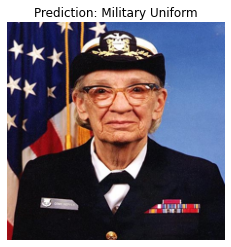

In [90]:

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [133]:
data_root = 'C:\\Users\\omxie\\.keras\\datasets\\eye_diseases'

In [134]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 228 images belonging to 5 classes.


In [135]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [136]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [137]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['neck brace', 'lipstick', 'Band Aid', 'lipstick', 'ice lolly',
       'web site', 'mask', 'bath towel', 'sunglasses', 'loupe', 'velvet',
       'face powder', 'wig', 'bearskin', 'hair spray', 'loudspeaker',
       'pencil sharpener', 'face powder', 'ski mask', 'langur',
       'face powder', 'whistle', 'bathtub', 'gong', 'velvet', 'lipstick',
       'thunder snake', 'baboon', 'Persian cat', 'hog', 'gong',
       'thunder snake'], dtype='<U30')

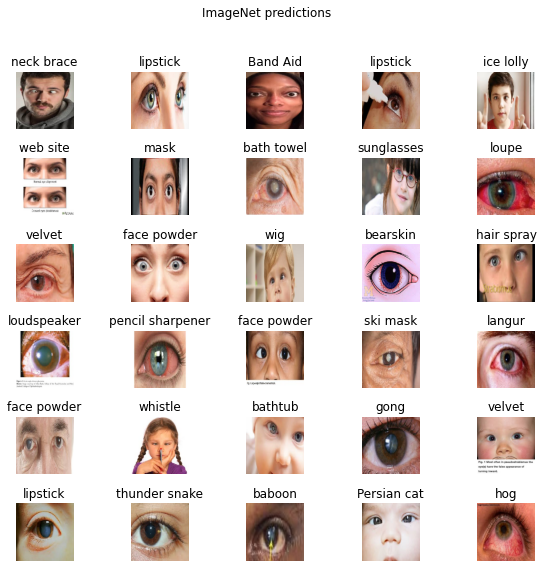

In [138]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [139]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4" 

In [140]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [141]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [142]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [143]:
predictions = model(image_batch)

In [144]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [145]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [152]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=8,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/8
8/8 [==============================] - 6s 729ms/step - loss: 0.5521 - acc: 0.7188
Epoch 2/8
8/8 [==============================] - 5s 664ms/step - loss: 0.6779 - acc: 0.7812
Epoch 3/8
8/8 [==============================] - 5s 634ms/step - loss: 0.5227 - acc: 0.8438
Epoch 4/8
8/8 [==============================] - 5s 647ms/step - loss: 0.5687 - acc: 0.8750
Epoch 5/8
8/8 [==============================] - 5s 648ms/step - loss: 0.3270 - acc: 0.9375
Epoch 6/8
8/8 [==============================] - 5s 660ms/step - loss: 0.4835 - acc: 0.8750
Epoch 7/8
8/8 [==============================] - 5s 654ms/step - loss: 0.3713 - acc: 0.9375
Epoch 8/8
8/8 [==============================] - 5s 668ms/step - loss: 0.3608 - acc: 0.9375


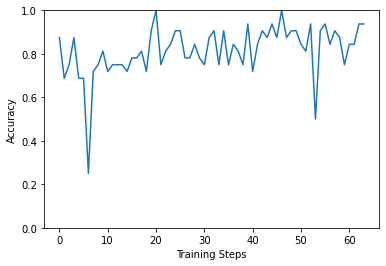

In [153]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [154]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Bulging_Eyes', 'Cataracts', 'Crossed_Eyes', 'Glaucoma', 'Uveitis'],
      dtype='<U12')

In [155]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [156]:
label_id = np.argmax(label_batch, axis=-1)

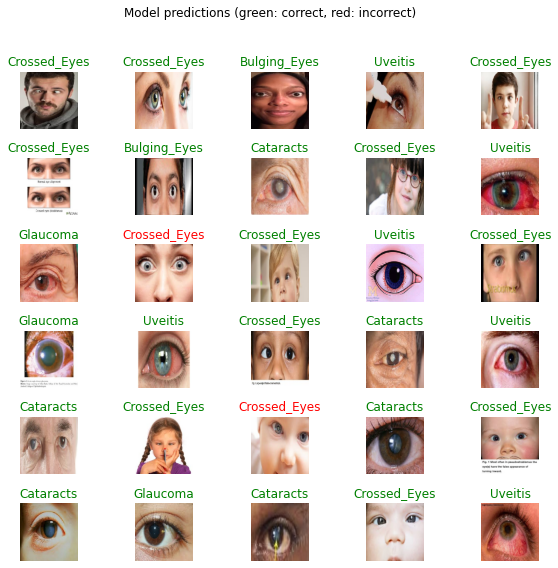

In [157]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1601202190\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1601202190\assets
